# Задача
Напишите скрипт для сборки отчета по ленте новостей. Отчет должен состоять из двух частей:
- текст с информацией о значениях ключевых метрик за предыдущий день
- график с значениями метрик за предыдущие 7 дней

Отобразите в отчете следующие ключевые метрики: 
- DAU 
- Просмотры
- Лайки
- CTR


# Решение

In [1]:
import pandas as pd
import numpy as np

import pandahouse as ph

# from airflow.decorators import dag, task
# from airflow.operators.python import get_current_context

from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 
    'user': 'student',
    'database': 'simulator'
}
db='simulator_20240320'

default_args = {
    'owner': 'v.grabchuk',
    'depends_on_past': True,
    'retries': 2,
    'retry_delay': timedelta(minutes=1),
    'start_date': datetime(2024, 2, 3),
}

# # Интервал запуска DAG
# schedule_interval = '1 0 * * *'

In [3]:
def get_metrics():
    # Статистика юзеров в feed_actions
    today = pd.Timestamp.today().date().strftime('%Y-%m-%d')
    today = f"'{today}'"
#     context = get_current_context()
#     today = context['ds']
#     today = f"'{today}'"
    q = f"""
    SELECT
        toDate(time) AS date,
        COUNT(DISTINCT user_id) AS DAU,
        countIf(action='view') AS views,
        countIf(action='like') AS likes,
        ROUND(likes / views, 3) as CTR
    FROM {db}.feed_actions
    WHERE 
        date < {today}
        AND date+7 >= {today}
    GROUP BY date
    """
    df = ph.read_clickhouse(q, connection=connection)
    return df

In [4]:
df = get_metrics()
df

,date,DAU,views,likes,CTR
0,2024-04-22,18379,623236,128754,0.207
1,2024-04-23,18438,717487,151832,0.212
2,2024-04-24,18673,785880,169223,0.215
3,2024-04-25,18594,722608,156103,0.216
4,2024-04-26,18300,704717,152089,0.216
5,2024-04-27,18729,749646,159808,0.213
6,2024-04-28,19017,633584,131578,0.208


In [5]:
def get_prev_day_text_report(df):
    # Текстовый отчёт за предыдущий день
    data = df.astype({'date': str}).iloc[-1]
    prev_day_report = ''.join(f'{k}:\t{v}\n' for k, v in zip(data.index, data.values))
    return prev_day_report

In [6]:
text_report = get_prev_day_text_report(df)
text_report

'date:\t2024-04-28\nDAU:\t19017\nviews:\t633584\nlikes:\t131578\nCTR:\t0.208\n'

In [24]:
    def get_lineplot(df, x, y, xrotation=0, color='b', **kwargs):
        # Возвращает lineplot
        ax = sns.lineplot(data=df, x=x, y=y, color=color, marker='o', **kwargs)
        ax.grid()
        ax.set_title(y)
        ax.tick_params(axis='x', labelrotation=xrotation)

        for x, y, m in zip(df[x], df[y], df[y].astype(str)):
            ax.text(x, y, m, color=color)
        return ax

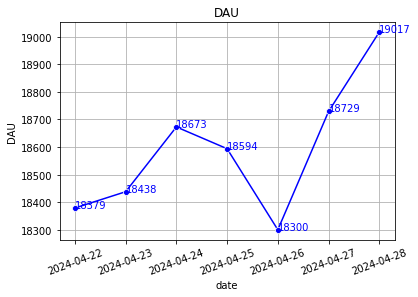

In [8]:
ax = get_lineplot(df, x='date', y='DAU');

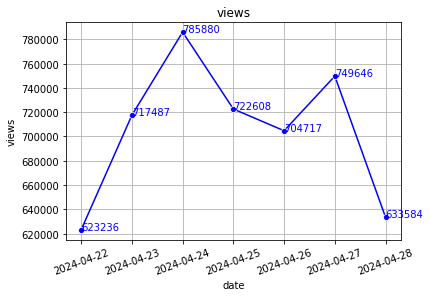

In [9]:
get_lineplot(df, x='date', y='views');

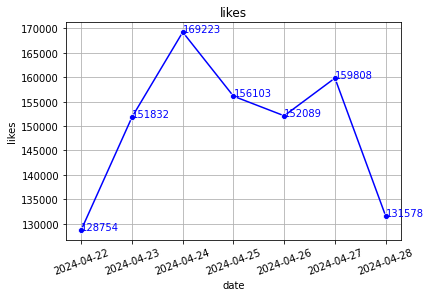

In [10]:
get_lineplot(df, x='date', y='likes');

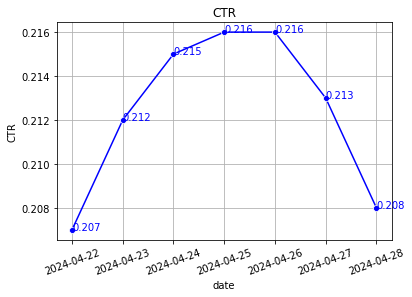

In [11]:
get_lineplot(df, x='date', y='CTR');

# Бот

In [12]:
import telegram
import io

In [13]:
my_token = 
bot = telegram.Bot(token=my_token)

In [14]:
chat_id = 

In [15]:
def report_message(bot, chat_id, text):
    # Отправка сообщения
    bot.sendMessage(chat_id=chat_id, text=text)

In [16]:
report_message(bot, chat_id, text_report)

In [32]:
def get_plots(df):
    # Возвращает все графики на одном полотне
    size = (4, 1)
    figsize = (8, 16)

    fig, ax = plt.subplots(*size, figsize=figsize)

    ax = plt.subplot(*size, 1);
    get_lineplot(df, x='date', y='DAU', color='r', ax=ax);
    ax = plt.subplot(*size, 2);
    get_lineplot(df, x='date', y='views', color='g', ax=ax);
    ax = plt.subplot(*size, 3);
    get_lineplot(df, x='date', y='likes', color='b', ax=ax);
    ax = plt.subplot(*size, 4);
    get_lineplot(df, x='date', y='CTR', color='y', ax=ax);

    fig.tight_layout()

    return fig

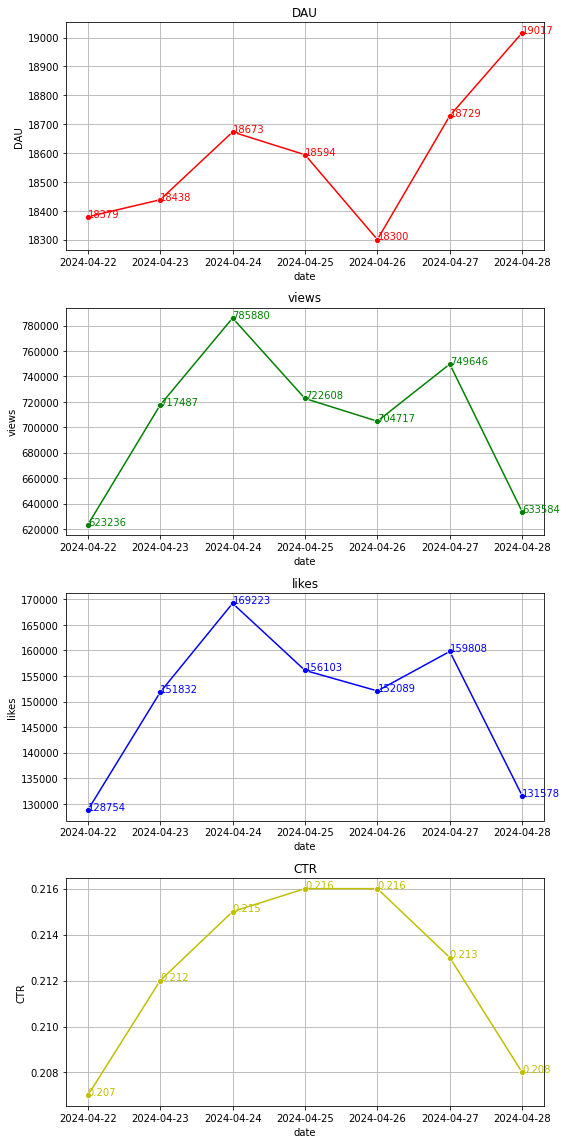

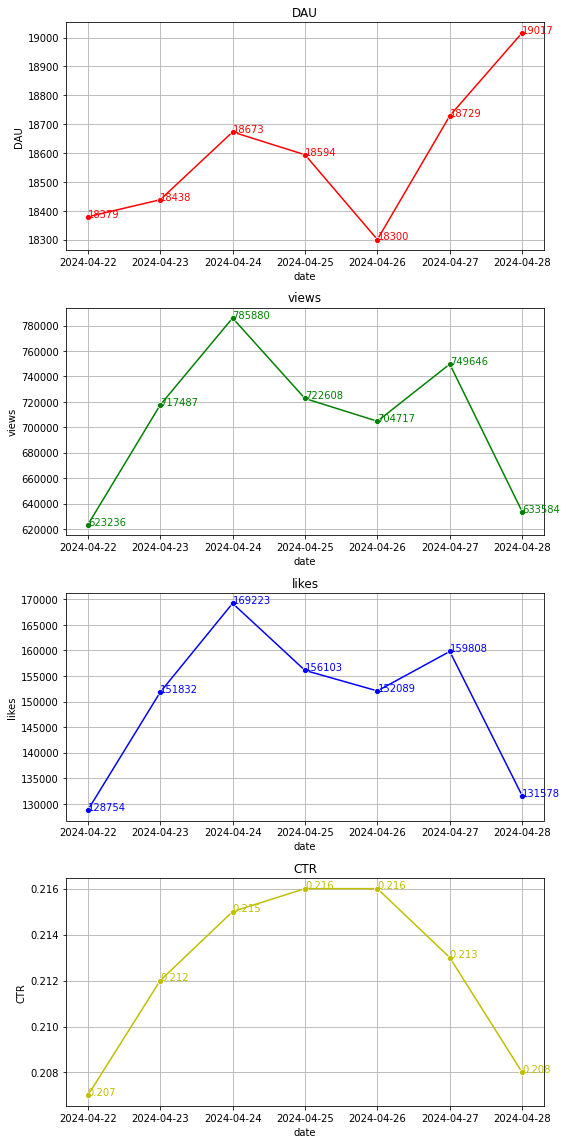

In [33]:
get_plots(df)

In [20]:
def report_image(bot, chat_id, plot):
    # Отправка изображения
    plot;
    plot = io.BytesIO()
    plt.savefig(plot, format='png', bbox_inches='tight')
    plot.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=chat_id, photo=plot)

In [18]:
# Графики по одному
plot = get_lineplot(df, x='date', y='views');
report_image(bot, chat_id, plot)

In [21]:
plot = get_plots(df);
report_image(bot, chat_id, plot)

In [ ]:
# Отправка файла
data = Getch('select * from simulator.feed_actions where toDate(time) = today() limit 100').df
file_object = io.StringIO()
data.to_csv(file_object)
file_object.name = 'test_file.csv'
file_object.seek(0)
bot.sendDocument(chat_id=chat_id, document=file_object)